In [74]:
import implicit
import numpy as np
import pandas as pd
import turicreate as tc

from implicit import evaluation
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from matplotlib import pyplot as plt
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix, hstack

import tqdm as notebook_tqdm

In [10]:
# Set a larger value for max_colwidth to avoid clipping of text in the final column
pd.set_option('max_colwidth', 500)

# Recommending Achievements to Steam Game Players

In this notebook, we compare recommender system approaches for determining the suitability of in-game achievements to players of a particular game. Since achievements can only be unlocked once, each cell in the interaction matrix between players and achievements can have value 0 or 1, and we treat the scenario as an implicit user feedback recommendation problem. For this reason, models and libraries such as <a href="https://surprise.readthedocs.io/en/stable/index.html">Surprise</a> which are designed exclusively for use with explicit ratings data are unsuitable and out of scope. We consider a few model variants from the <a href="https://github.com/apple/turicreate">TuriCreate</a>, <a href="https://github.com/benfred/implicit">Implicit</a> and <a href="https://making.lyst.com/lightfm/docs/lightfm.html">LightFM</a> libraries:

* TuriCreate - Popularity-Based (baseline)
* TuriCreate - Jaccard Similarity between items
* TuriCreate - SGD-based Ranking-Factorization
* TuriCreate - implicit Alternative Least Squares-based Ranking-Factorization 
* Implicit - Cosine, TFIDF, BM25 Nerest-Neighbour Recommenders
* LightFM - Bayesian Personalised Ranking pairwise loss (BPR)
* LightFM - Weighted Approximate-Rank Pairwise loss (WARP)
* LightFM - Weighted Approximate-Rank Pairwise loss (WARP) with Player Representations

Unlike similar scenarios such as recommending movies based on a record of the movies a user has already watched, we can't assume _intent_: a player may unlock achievements which are part of a linear games' main storyline, or stumble across (sometimes deliberately hidden) achievements by accident.

#### Producing recommendations

We're interested in putting a monetary value on each achievement in the game for the given player. To produce recommendations, we:

1. Score every achievement in the game using the model
2. Rank these scores
3. Remove achievements in the players known set

#### Evaluating the models

##### Precision at k
Each library we use has a built-in "precision at k" metric. Let *p<sub>k</sub>* be a vector of the _k_ highest ranked recommendations for a particular user, and let _a_ be the set of items for that user in the groundtruth dataset. The “precision at k” is defined as

$$
P(k) = \frac{|a \cap p_k|}{k}
$$

##### Proportion of long-tail items
For some models, as a way of assessing the tendency of a model to recommend popular items, we also look at the proportion of recommended items in the top k which come from the "long tail" of the 80% least-popular items in the dataset. The motivation behind this metric is that recommendations from the long tail will be more diverse, more personalised, lead to more discovery and greater user satisfaction.

### Dataset Assembly

We consider collections of players of `Grand Theft Auto 5`, `Cyberpunk 2077` and `Buldar's Gate 3`.

In [11]:
# Retrieve data describing all possible achievements
df_achievements = pd.read_csv('./data/buldars_gate_3_achievements_2023-11-04.csv')
df_achievements.head()

,name,defaultvalue,displayName,hidden,description,icon,icongray,player_count
0,BG3_Quest01,0,Descent From Avernus,0,Take control of the nautiloid and escape the Hells.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0cb31fd9ec036550a374aa702a37464a98da3bfa.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0950821dd57b97eb5ce309530dd61f0e3f2e3a6d.jpg,2568
1,BG3_Quest02,0,The Plot Thickens,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/628cdbbfd2e731735e4817252ce6633bf3bcd8ed.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/4127925c4aeb79134a98de629e7918ceb776b4fb.jpg,2104
2,BG3_Quest03,0,The City Awaits,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/3c6d05ff648b66925238963a658ee307e31ff870.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/092cc30e865fbb0158afe43fb343d6362e9292fa.jpg,1717
3,BG3_Quest04,0,All's Well That Ends Well,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/ecd435323119579216ebcffebae690ae2e5c13eb.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/c4307d65a1d8c9776f71e73494248b546e4135d8.jpg,1031
4,BG3_Quest05,0,Absolute Power Corrupts,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/265327d387174ee2160946bcde392352ce635b88.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/749d41e10cac54dbeb2b377d8bc69b2afdfbae62.jpg,253


What proportion of the achievements registered in the game schema actually have descriptions?

In [12]:
print(f"{df_achievements['description'].notna().mean() * 100:.1f}% of achievements come with descriptions.")

45.3% of achievements come with descriptions.


In [13]:
# Retrieve data describing players' achievements
df_players = pd.read_csv('./data/buldars_gate_3_players_2023-11-04.csv', index_col='steam_id')
df_players

,BG3_Quest01,BG3_Quest02,BG3_Quest03,BG3_Quest04,BG3_Quest05,BG3_Quest06,BG3_Quest07,BG3_Quest08,BG3_Quest09,BG3_Quest10,...,BG3_Quest44,BG3_Quest45,BG3_Quest46,BG3_Quest47,BG3_Quest48,BG3_Quest49,BG3_Quest50,BG3_Quest51,BG3_Quest52,BG3_Quest53
steam_id,,,,,,,,,,,,,,,,,,,,,
76561199004154858,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
76561199058333673,1,1,1,1,0,1,0,0,1,1,...,0,0,0,1,0,0,1,1,0,0
76561198016380377,1,1,1,1,0,1,0,0,1,1,...,0,1,1,0,1,0,1,1,0,0
76561198898124688,1,1,1,0,0,0,0,0,1,1,...,0,1,1,1,0,0,1,1,0,0
76561198011137973,1,1,1,0,0,0,0,0,1,1,...,0,0,1,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198137518354,1,1,1,0,0,0,0,0,1,1,...,0,1,1,0,1,0,0,1,0,0
76561198115832615,1,1,0,0,0,0,0,0,1,1,...,1,1,1,1,0,0,1,0,0,0
76561198056016073,1,1,1,1,0,1,0,1,1,1,...,0,0,1,1,0,1,1,1,0,0


In [14]:
# Read in selected player statistics (number of games owned, playtime_forever for selected game)
df_play_stats = pd.read_csv('./data/buldars_gate_3_play_stats_2023-11-04.csv', index_col='steamid')
df_play_stats

,num_games_owned,playtime_forever
steamid,,
76561199004154858,290,5567
76561199058333673,120,4204
76561198016380377,218,9200
76561198898124688,47,13942
76561198011137973,289,11385
...,...,...
76561198137518354,310,9125
76561198115832615,136,30767
76561198056016073,541,9453


What does the completion of achievements look like amongst this set of players?

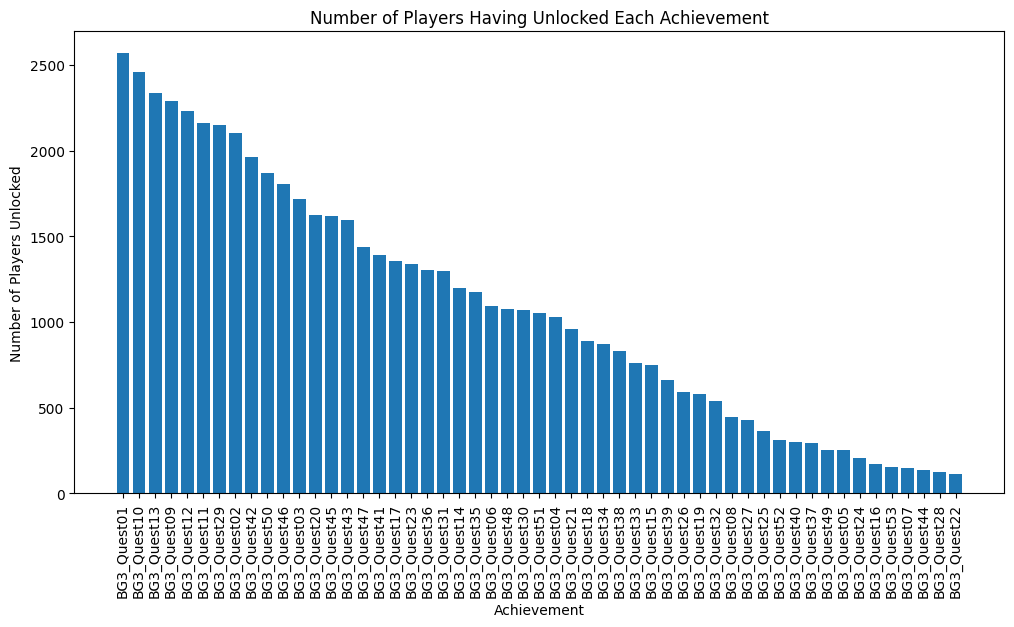

In [15]:
achievement_counts = (
    df_achievements[['name', 'player_count']]
    .rename(columns={'name': 'Achievement', 'player_count': 'Count'})
    .sort_values(by='Count', ascending=False)
)

# Plot a chart of player counts for achievements in descending order
plt.figure(figsize=(12, 6))
plt.bar(achievement_counts['Achievement'], achievement_counts['Count'])
plt.xlabel('Achievement')
plt.ylabel('Number of Players Unlocked')
plt.title('Number of Players Having Unlocked Each Achievement')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Top 5 most unlocked achievements
df_achievements.sort_values(by='player_count', ascending=False).head(5)

,name,defaultvalue,displayName,hidden,description,icon,icongray,player_count
0,BG3_Quest01,0,Descent From Avernus,0,Take control of the nautiloid and escape the Hells.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0cb31fd9ec036550a374aa702a37464a98da3bfa.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0950821dd57b97eb5ce309530dd61f0e3f2e3a6d.jpg,2568
9,BG3_Quest10,0,Bedrolls and Breakfast,0,Take four full Long Rests in a single playthrough - adventuring's tiring work.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/47daa8cf213809978d0f2ba9b514942c864ce452.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/042a397825694c4147bf6fc9bd580890b71573e7.jpg,2458
12,BG3_Quest13,0,No Penny Required,0,Successfully use Detect Thoughts to pry into someone's thoughts.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/c77588e8a25741098ac71ae64f4b08d84e357310.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/b2c45774e06a96ac4c091aa6525d1f3b389c499c.jpg,2336
8,BG3_Quest09,0,Roleplayer,0,Complete ten background goals in a single playthrough - you are one with your character.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/9c1231f530788d9aa21e1a858fbb9e85e0cb64f8.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/6b55d2fb4ef8fbf7fe7605b561b95a762ea74ded.jpg,2289
11,BG3_Quest12,0,Dig for Victory,0,Dig up five buried chests in a single playthrough - treasure!,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0dfd51a7ae1c5e122d1b46051d23234f5c5f681d.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/6ed09414918b95892c3c26558c800de7e79de03c.jpg,2230


In [17]:
def player_precision_at_k(scores, known_items, k=10):
    """
    Calculates the precision_at_k metric for a single player.
    Takes:
    - scores = a Series of recommendation scores, indexed by apiname
    - known_items = a list of the apiname of known achievements for the player
    Returns:
    - precision_at_k = the fraction of known positives in the first k positions
    of the ranked list of scores
    """
    top_k_scores = scores.sort_values(ascending=False).head(k)
    precision_at_k = len(set(known_items).intersection(top_k_scores.index)) / k
    
    return precision_at_k

def get_recommended_achievement_descriptions(scores, achievements):
    """
    Creates a table displaying the descriptions for the achievements in a
    set of achievement scores.
    Takes:
    - scores - a Pandas series of recommended achievement scores, indexed by apiname
    - achievements - a Pandas Dataframe with columns for API name and description
    Returns:
    - a table showing descriptions for each recommendation
    """
    scores.name = 'score'
    recommended_achievements = pd.merge(scores, achievements, left_index=True, right_on='name')
    recommended_achievements.set_index('name', inplace=True)
    recommended_achievements = recommended_achievements[['score', 'description']]

    return recommended_achievements

def display_recommended_achievements(player_of_interest, scores, known_achievements, recommended_achievements):
    """
    Displays the player's steam ID, descriptions of known achievements, and recommended achievements.
    Takes:
    - player_of_interest = Steam ID of the player of interest
    - scores = a Series of all scores
    - known_achievements = a list of apinames of the player's known achievements
    - recommended_achievements = a Series of scores, minus the known achievements
    """
    print(f"Player Steam ID: {player_of_interest}")
    print("Known achievements:")
    display(df_achievements[df_achievements['name'].isin(known_achievements)][['name', 'description']])
    print("Top 5 recommendations:")
    display(get_recommended_achievement_descriptions(recommended_achievements, df_achievements)[:5])
    print(f"Precision at k=10 score: {player_precision_at_k(scores, known_achievements, k=10)}")

### TuriCreate

#### Popularity Recommender
To serve as a baseline to improve upon, we evaluate a simple popularity recommender, where items are scored by the number of times they appear in the training data, and recommendations are the same for all users.

In [18]:
# Covert the player-achievement interaction matrix into a format suitable for TuriCreate.
# TuriCreate's ItemSimilarityRecommender expects an `SFrame` object whose rows represent interactions,
# and which has columns `user_id` and `item_id`

# Use the melt function to reshape the DataFrame
df_melted = pd.melt(df_players.reset_index(), id_vars='steam_id', var_name='item_id', value_name='interaction')
df_melted.columns = ['user_id', 'item_id', 'interaction']

#Filter out rows where 'interaction' is 0
df_melted = df_melted[df_melted['interaction'] == 1]
df_melted.reset_index(drop=True, inplace=True)
df_melted.drop(columns=['interaction'], inplace=True)

sf = tc.SFrame(df_melted)
sf.head(5)

user_id,item_id
76561199004154858,BG3_Quest01
76561199058333673,BG3_Quest01
76561198016380377,BG3_Quest01
76561198898124688,BG3_Quest01
76561198011137973,BG3_Quest01


In [19]:
# Split the player-achievement interactions into train and test sets for TuriCreate
train, test = tc.recommender.util.random_split_by_user(sf, random_seed=42, item_test_proportion=0.3, max_num_users=None)

In [20]:
model_popularity = tc.popularity_recommender.create(train, verbose=False)

In [21]:
# Get the precision_at_k and recall_at_k evaluation for the model using this train/test split. 
# We pass the cutoffs(k) as a kwarg 
# Because the evaluation dataset (test) is different from the data used for training the model (train), we set exclude_known_for_precision_recall to False
eval = model_popularity.evaluate(test, exclude_known_for_precision_recall=True, metric='precision_recall', cutoffs=[10])

recommendations finished on 1000/2502 queries. users per second: 1.14155e+06

recommendations finished on 2000/2502 queries. users per second: 1.26183e+06


Precision and recall summary statistics by cutoff
+--------+--------------------+--------------------+
| cutoff |   mean_precision   |    mean_recall     |
+--------+--------------------+--------------------+
|   10   | 0.5038369304556356 | 0.7675812235836947 |
+--------+--------------------+--------------------+
[1 rows x 3 columns]




#### Jaccard Similarity Recommender
We use the `ItemSimilarityRecommender` class from the <a href="https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.item_similarity_recommender.ItemSimilarityRecommender.html#turicreate.recommender.item_similarity_recommender.ItemSimilarityRecommender">TuriCreate</a> library to construct a recommender which considers the Jaccard similarity between items to produce scores.

In [22]:
# Create an ItemSimilarityRecommender (uses Jaccard similarity between items for scoring)
model_jaccard_similarity = tc.item_similarity_recommender.create(train, verbose=False)

In [23]:
# Get the precision_at_k and recall_at_k evaluation for the model using this train/test split. 
# We pass the cutoffs(k) as a kwarg 
# Because the evaluation dataset (test) is different from the data used for training the model (train), we set exclude_known_for_precision_recall to False
eval = model_jaccard_similarity.evaluate(test, exclude_known_for_precision_recall=True, metric='precision_recall', cutoffs=[10])

recommendations finished on 1000/2502 queries. users per second: 809717

recommendations finished on 2000/2502 queries. users per second: 861698


Precision and recall summary statistics by cutoff
+--------+--------------------+-------------------+
| cutoff |   mean_precision   |    mean_recall    |
+--------+--------------------+-------------------+
|   10   | 0.5095523581135092 | 0.768439345254454 |
+--------+--------------------+-------------------+
[1 rows x 3 columns]



We use this Jaccard similarity model to produce a set of ranked recommendation scores for a given user. 

In [24]:
player_of_interest = df_players.index[4] # Steam ID of player of interest

# Retrieve the ranked recommendations for this player (note: we deliberately do not filter known achievements for comparison purposes)
recommendation_scores = model_jaccard_similarity.recommend(users=[player_of_interest], k=len(df_players.columns), exclude_known=False)
scores = pd.Series(recommendation_scores['score'], index=np.array(recommendation_scores['item_id']))
series_of_interest = df_players.loc[player_of_interest]
known_achievements = series_of_interest[series_of_interest == 1].index.tolist()
# Get a list of actual recommendations by removing the already known achievements
recommended_achievements = scores[~scores.index.isin(known_achievements)]
display_recommended_achievements(player_of_interest, scores, known_achievements, recommended_achievements)

Player Steam ID: 76561198011137973
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
1,BG3_Quest02,NaN
2,BG3_Quest03,NaN
8,BG3_Quest09,Complete ten background goals in a single playthrough - you are one with your character.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
13,BG3_Quest14,Break out of prison after being arrested - aren't you daring?
19,BG3_Quest20,NaN
25,BG3_Quest26,NaN


Top 5 recommendations:


,score,description
name,,
BG3_Quest12,0.349695,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest43,0.322351,"Read 100 different books in a single playthrough. Adventuring isn't just daring quests, you know."
BG3_Quest45,0.306629,Play fetch with Scratch - the best boy in the Realms.
BG3_Quest23,0.300363,NaN
BG3_Quest36,0.293294,NaN


Precision at k=10 score: 0.8


#### Ranking Factorization Recommender

When working with implicit data, TuriCreate's ranking factorization model has two solvers, one which uses a randomized stochastic gradient descent (sgd)-based method to tune the results, and the other which uses an implicit form of alternating least squares (iALS). 

The default sgd-based method samples unobserved items along with the observed ones, then treats them as negative examples. This is the default solver. 

Implicit ALS is a version of the popular Alternating Least Squares (ALS) algorithm that attempts to find factors that distinguish between the given user-item pairs and all other negative examples. This algorithm can be faster than the sgd method, particularly if there are many items.

In [25]:
# Create and train a recommender using the default sgd solver
model_turicreate_ranking_factorization_sgd = tc.ranking_factorization_recommender.create(sf, verbose=False)
eval = model_turicreate_ranking_factorization_sgd.evaluate(test, exclude_known_for_precision_recall=False, metric='precision_recall', cutoffs=[10])

recommendations finished on 1000/2502 queries. users per second: 269687

recommendations finished on 2000/2502 queries. users per second: 449337


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   10   | 0.26514788169464426 | 0.4487554296784951 |
+--------+---------------------+--------------------+
[1 rows x 3 columns]



In [26]:
# Create and train a recommender using the ials solver
model_turicreate_ranking_factorization_ials = tc.ranking_factorization_recommender.create(sf, solver='ials', verbose=False)
eval = model_turicreate_ranking_factorization_ials.evaluate(test, exclude_known_for_precision_recall=False, metric='precision_recall', cutoffs=[10])


recommendations finished on 1000/2502 queries. users per second: 1.1236e+06

recommendations finished on 2000/2502 queries. users per second: 1.26422e+06


Precision and recall summary statistics by cutoff
+--------+---------------------+--------------------+
| cutoff |    mean_precision   |    mean_recall     |
+--------+---------------------+--------------------+
|   10   | 0.28844924060751403 | 0.5181558642882055 |
+--------+---------------------+--------------------+
[1 rows x 3 columns]



In [27]:
# Create a lookup dictionary of steam_ids and achievement apinames for use with Implicit and LightFM
player_dict = dict(
    zip(
        df_players.index, 
        range(len(df_players.index))
    )
)

achievement_dict = dict(
    zip(
        range(len(df_players.columns)),
        df_players.columns.values
    )
)

In [28]:
def sample_recommendation_player_implicit(model, df, steam_id, player_dict, achievement_dict, show=False):
    """
    Function for producing user recommendations.
    Takes:
    - model = a trained Implicit model
    - df = a DataFrame describing the achievements of players. Has column
    for steam_id and a binary column for each achievement in the game
    - steam_id = the steam id of the player to produce recommendations for
    - player_dict = dictionary mapping steam_ids to the internal id used by Implicit
    - achievement_dict = dictionary mapping achievement internal id to apinames
    user by Implicit
    Returns:
    - scores - a Series of all scores
    - known_items - a list of the apinames of known achievements of the player
    - recommended_items - a Series of scores, minus the known achievements
    """
    known_player_achievements = sparse.csr_matrix(
        df.loc[steam_id]
        .values
        .astype(np.float32))
    ids, scores = model.recommend(
        player_dict[steam_id], 
        known_player_achievements, 
        N=len(achievement_dict.keys()), 
        filter_already_liked_items=False)
    scores = pd.Series(scores, index=ids).sort_index()
    scores.index = scores.index.map(achievement_dict)
    scores = scores.sort_values(ascending=False)
    player_row = df.loc[steam_id]
    known_items = player_row[player_row == 1].index.tolist()
    recommended_items = scores.drop(known_items)

    if show:
        display_recommended_achievements(steam_id, scores, known_items, recommended_items)

    return scores, known_items, recommended_items

def sample_recommendation_player_lightfm(model, df, steam_id, player_dict, achievement_dict, show=False):
    """
    Function for producing user recommendations.
    Takes:
    - model = a trained LightFM model
    - df = a DataFrame describing the achievements of players. Has column
    for steam_id and a binary column for each achievement in the game
    - steam_id = the steam id of the player to produce recommendations for
    - player_dict = dictionary mapping steam_ids to the internal id used by LightFM
    - achievement_dict = dictionary mapping achievement internal id to apinames
    user by LightFM
    Returns:
    - scores - a Series of all scores
    - known_items - a list of the apinames of known achievements of the player
    - recommended_items - a Series of scores, minus the known achievements
    """
    scores = pd.Series(
        model.predict(
            player_dict[steam_id], 
            [key for key in achievement_dict.keys()]
        )
    )
    scores.index = achievement_dict.values()
    scores = scores.sort_values(ascending=False)
    player_row = df.loc[steam_id]
    known_items = player_row[player_row == 1].index.tolist()
    recommended_items = scores.drop(known_items)

    if show:
        display_recommended_achievements(steam_id, scores, known_items, recommended_items)

    return scores, known_items, recommended_items

def get_implicit_model_evaluation(model, train, test, K=10, show=False):
    """
    Evaluates the given model using precision_at_k and AUC_at_k methods. 
    Optionally prints the evaluation.
    Takes:
    - model = a trained implicit model
    - train = the numpy sparse coo_matrix that the model was trained on
    - test = the numpy sparse coo_matrix of the test data
    - K = the number of top recommendations to consider for evaluation
    - show = Boolean indication whether the evaluation should be printed
    Returns:
    - a tuple of precision_at_k, AUC_at_k
    """
    precision = evaluation.precision_at_k(model, train.astype(np.float32), test.astype(np.float32), K)
    auc = evaluation.AUC_at_k(model, train.astype(np.float32), test.astype(np.float32), K)
    ndcg = evaluation.ndcg_at_k(model, train.astype(np.float32), test.astype(np.float32), K)

    if show:
        print("Precision: %.2f." % (precision))
        print("AUC: %.2f" % (auc))
        print("NDCG: %.2f" % (ndcg))
        
    return precision, auc, ndcg


Many recommender systems suffer from popularity bias, where they emphasise items with more interactions over other 'long-tail' items.

Following the approach in <a href="https://arxiv.org/pdf/1901.07555.pdf">https://arxiv.org/pdf/1901.07555.pdf</a>, we define functions for measuring how much a model recommends achievements from the long tail, defined as the 80% least-commonly occurring achievements in the training dataset. 

We consider the metric:

<b>Average Percentage of Long Tail Items (APLT)</b><br>
The average percentage of long tail items in the top K=10 of the recommended achievement lists

In [29]:
def average_proportion_long_tail_at_k(model, df, K=10, filter_already_liked_items=True):
    """
    Calculates the average proportion of the top K achievements recommended
    by the model to each player which appear in the popularity long tail (bottom 20%).
    Takes:
    - model = a trained implicit model
    - df = a Pandas DataFrame with columns for Steam ID and player interactions with each achievement
    - K = the number of top recommendations to consider
    - filter_already_liked_items = whether to filter achievements that the player has already
    interacted with from recommendations when calculating the proportion 
    Returns: 
    The average proportion of top K recommendations which appear in the long tail
    """
    # Get the achievement indices of the long tail
    achievement_popularities = df.sum(axis=0)
    achievement_popularities.index = range(len(achievement_popularities.index))
    achievement_popularities = achievement_popularities.sort_values(ascending=False)
    long_tail = achievement_popularities.iloc[int(len(achievement_popularities) * 0.2):].index.to_numpy()

    # Get the indices for the recommended achievements
    inds, _ = model.recommend(
        [x for x in range(df.shape[0])], 
        sparse.csr_matrix(df.values.astype(np.float32)), 
        N=K, 
        filter_already_liked_items=filter_already_liked_items
    )

    # Convert the lists in test_inds to NumPy arrays
    inds_arrays = [np.array(lst) for lst in inds]

    # Create a boolean mask for common elements
    common_elements_mask = np.isin(inds_arrays, long_tail)
    proportions = common_elements_mask.sum(axis=1) / np.array([len(lst) for lst in inds])
    
    return proportions.mean()

In [30]:
# Implicit and LightFM both require the data to be a numpy sparse coo_matrix (COOrdinate format)
# Randomly assign 20% of all interaction pairs to the test set
train, test = random_train_test_split(
    sparse.coo_matrix(df_players), 
    test_percentage=0.3,
    random_state=42 
)

### Implicit Nearest Neighbour Models

We compare the performance of several models from the <a href="https://benfred.github.io/implicit/api/models/cpu/als.html">Implicit</a> library's family of item-item nearest neighbour models.

#### Cosine Recommender
Train an item-item recommender based on the cosine distances between items.

In [31]:
model_implicit_cosine = implicit.nearest_neighbours.CosineRecommender(K=20) # Use K=20 items in the neighbourhood
model_implicit_cosine.fit(train)

/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0023322105407714844 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 1051.99it/s]


In [32]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the cosine distance model
precision_implicit_cosine, auc_implicit_cosine, ndcg_implicit_cosine = get_implicit_model_evaluation(model_implicit_cosine, train, test, show=True)

100%|██████████| 2518/2518 [00:00<00:00, 28545.79it/s]

Precision: 0.78.
AUC: 0.85
NDCG: 0.76


#### TFIDF Recommender

Train a recommender using TF-IDF distances between achievements.

In [33]:
model_implicit_tfidf = implicit.nearest_neighbours.TFIDFRecommender(K=20) # Use K=20 items in the neighbourhood
model_implicit_tfidf.fit(train)

/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0005831718444824219 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 2837.93it/s]


In [34]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the TF-IDF distance model
precision_implicit_tfidf, auc_implicit_tfidf, ndcg_implicit_tfidf = get_implicit_model_evaluation(model_implicit_tfidf, train, test, show=True)

# Calculate the proportion of top 10 recommended items which belong to the popularity "long tail"
aplt_at_k_tfidf = average_proportion_long_tail_at_k(model_implicit_tfidf, df_players, K=10, filter_already_liked_items=False)
print(f"Average Percentage of Long Tail Items: {aplt_at_k_tfidf * 100 :.1f}%")

100%|██████████| 2518/2518 [00:00<00:00, 22414.72it/s]


Precision: 0.78.
AUC: 0.85
NDCG: 0.76
Average Percentage of Long Tail Items: 29.7%


The TF-IDF distance recommender, on average, pulls about 30% of the top 10 recommendations for the player from the "long tail" of popular achievements.

#### BM25 Recommender

Train a model using the BM25 distance between achievements.

In [35]:
model_implicit_bm25 = implicit.nearest_neighbours.BM25Recommender(K=20) # Use K=20 items in the neighbourhood
model_implicit_bm25.fit(train)

/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0002899169921875 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 2536.38it/s]


In [36]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the BM25 distance model
precision_implicit_bm25, auc_implicit_bm25, ndcg_implcit_bm25 = get_implicit_model_evaluation(model_implicit_bm25, train, test, show=True)

100%|██████████| 2518/2518 [00:00<00:00, 27175.47it/s]

Precision: 0.78.
AUC: 0.86
NDCG: 0.79


We retrieve recommendations for a given player using Implicit's TF-IDF similarity recommender:

In [37]:
# Get known achievements and recommended achievements for first player using Implicit cosine
player_of_interest = df_players.index[0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_implicit(
    model_implicit_tfidf, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest09,5.294645,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest12,5.137244,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest02,4.932207,NaN
BG3_Quest46,4.612901,NaN
BG3_Quest20,4.373751,NaN


Precision at k=10 score: 0.7


### Implicit Matrix Factorization Models

We attempt to fit several of the models from Implicit's family of Matrix Factorization models.

####  Alternating Least Squares
We evaluate the performance of Implicit's Alternating Least Squares model.

In [38]:
# Initialise an Implicit ALS model
model_implicit_als = implicit.als.AlternatingLeastSquares(random_state=42)
model_implicit_als.fit(train);

/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0006957054138183594 seconds
  warnings.warn(
  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  6.04it/s]


In [39]:
# Get the precision_at_k AUC_at_k and NDCG_at_k for the ALS model
precision_implicit_als, auc_implicit_als, ndcg_implicit_als  = get_implicit_model_evaluation(model_implicit_als, train, test, show=True)

100%|██████████| 2518/2518 [00:00<00:00, 5383.20it/s]

Precision: 0.44.
AUC: 0.61
NDCG: 0.36


In [40]:
# Get known achievements and recommended achievements for first player using Implicit ALS
player_of_interest = df_players.index[0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_implicit(
    model_implicit_als, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest19,0.002396,NaN
BG3_Quest39,0.001974,NaN
BG3_Quest37,0.001802,Defeat Gortash in Wyrm's Rock without activating any traps.
BG3_Quest44,0.001433,Defeat twenty opponents while a party character is drunk in a single playthough - down them.
BG3_Quest07,0.001307,NaN


Precision at k=10 score: 0.7


#### Logistic Matrix Factorization

We evaluate the performance of Implicit's Alternating Least Squares model.

In [41]:
# Initialise an Implicit Logistic Matrix Factorization model
model_implicit_lmf = implicit.lmf.LogisticMatrixFactorization(random_state=42)
model_implicit_lmf.fit(train);

/home/rich/anaconda3/envs/steam/lib/python3.8/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0005242824554443359 seconds
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 149.12it/s]


In [42]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the LMF model
precision_implicit_lmf, auc_implicit_lmf, ndcg_implicit_lmf = get_implicit_model_evaluation(model_implicit_lmf, train, test, show=True)

100%|██████████| 2518/2518 [00:00<00:00, 13875.60it/s]

Precision: 0.46.
AUC: 0.64
NDCG: 0.37


### LightFM
We train models from those available from <a href="https://making.lyst.com/lightfm/docs/home.html">LightFM</a> (paper available on <a href="https://arxiv.org/pdf/1507.08439.pdf">arxiv</a>).<br>
If we don't pass in any feature representations for players or achievements, LightFM reduces to a traditional collaborative filtering matrix factorization method.

In [43]:
def prepare_player_features(features):
    """
    Prepare player features for use with LightFM.
    Takes:
    - features = a DataFrame with columns for steam id and player features.
    Returns:
    - an np.float32 csr matrix of shape [n_players, n_player_features]
    """
    return sparse.csr_matrix(
        features
        .values
        .astype(np.float32)
    )

In [44]:
player_features = prepare_player_features(df_play_stats)

#### Bayesian Personalised Ranking pairwise loss (BPR)

Maximises the prediction difference between a positive example and a randomly chosen negative example. Otimises the ROC AUC metric.

In [45]:
# Train LightFM BPR model
model_lightfm_bpr = LightFM(learning_rate=0.05, loss='bpr', random_state=42)
# BPR: Bayesian Personalised Ranking pairwise loss. 
# Maximises the prediction difference between a positive example 
# and a randomly chosen negative example. 
# Useful when only positive interactions are present and optimising ROC AUC is desired.
model_lightfm_bpr.fit(train);

In [46]:
# The proportion of known positives that are within the first k results on the 
# list or recommendations
train_precision_bpr = precision_at_k(model_lightfm_bpr, train, k=10).mean()
test_precision_bpr = precision_at_k(model_lightfm_bpr, test, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_bpr = auc_score(model_lightfm_bpr, train).mean()
test_auc_bpr = auc_score(model_lightfm_bpr, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_bpr, test_precision_bpr))
print('AUC: train %.2f, test %.2f.' % (train_auc_bpr, test_auc_bpr))

Precision: train 0.60, test 0.26.
AUC: train 0.81, test 0.74.


In [47]:
# Get known achievements and recommended achievements for first player
player_of_interest = df_players.index[0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_lightfm(
    model_lightfm_bpr, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest09,0.366361,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest02,0.317568,NaN
BG3_Quest12,0.297659,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest46,0.155956,NaN
BG3_Quest03,0.069175,NaN


Precision at k=10 score: 0.6


#### Weighted Approximate-Rank Pairwise loss (WARP)

In [48]:
# Train LightFM WARP model
model_lightfm_warp = LightFM(learning_rate=0.05, loss='warp', random_state=42)
# WARP: Weighted Approximate-Rank Pairwise loss. 
# Maximises the rank of positive examples by repeatedly sampling negative examples 
# until rank violating one is found. 
# Useful when only positive interactions are present and optimising 
# the top of the recommendation list (precision_at_k) is desired.
model_lightfm_warp.fit(train);

In [49]:
# The proportion of known positives that are within the first k results on the 
# list or recommendations
train_precision_warp = precision_at_k(model_lightfm_warp, train, k=10).mean()
test_precision_warp = precision_at_k(model_lightfm_warp, test, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp = auc_score(model_lightfm_warp, train).mean()
test_auc_warp = auc_score(model_lightfm_warp, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp, test_precision_warp))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp, test_auc_warp))

Precision: train 0.62, test 0.25.
AUC: train 0.83, test 0.75.


In [50]:
# Get known achievements and recommended achievements for first player
player_of_interest = df_players.index[0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_lightfm(
    model_lightfm_warp, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest09,1.037071,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest02,0.849586,NaN
BG3_Quest12,0.811940,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest03,0.470173,NaN
BG3_Quest46,0.467790,NaN


Precision at k=10 score: 0.6


#### WARP Loss Model with Player Representations

We fit a WARP loss model with user features in order to train a "hybrid" model:

In [51]:
model_lightfm_warp_hybrid = LightFM(learning_rate=0.05, loss='warp', random_state=42)
model_lightfm_warp_hybrid.fit(train, player_features);


In [52]:
train_precision_warp_hybrid = precision_at_k(model_lightfm_warp_hybrid, train, user_features=player_features, k=10).mean()
test_precision_warp_hybrid = precision_at_k(model_lightfm_warp_hybrid, test, user_features=player_features, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp_hybrid = auc_score(model_lightfm_warp_hybrid, train, user_features=player_features).mean()
test_auc_warp_hybrid = auc_score(model_lightfm_warp_hybrid, test, user_features=player_features).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp_hybrid, test_precision_warp_hybrid))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp_hybrid, test_auc_warp_hybrid))

Precision: train 0.35, test 0.16.
AUC: train 0.64, test 0.61.


### Using Vector Representations of Players

In [89]:
def _preprocess_features_matrix(matrix: csr_matrix, n: int) -> csr_matrix:
    """
    According to LightFM docs, when supplying feature matrices, an implicit identity feature matrix will no longer
    be used. This may result in a less expressive model: because no per-user features are estimated, the model may
    underfit. To combat this, we should include per-user (per-item) features (that is, an identity matrix) as part
    of the feature matrix you supply.
    :param matrix: feature matrix (items or users)
    :type matrix: csr_matrix
    :param n: number of users or number of items
    :type n: int
    :return: feature matrix concatenated to an identity matrix
    :rtype: csr_matrix
    """
    return csr_matrix(hstack([np.identity(n), matrix]))


class CustomLightFM(LightFM):
    def fit(
            self,
            user_interactions_matrix: csr_matrix,
            user_features_matrix: csr_matrix = None,
            item_features_matrix: csr_matrix = None):
        """
        Custom fit method to fit the FM model to the user interactions passed and with the specified parameters.
        user_features_matrix and item_features_matrix are optional and allow for hybrid approaches.
        It runs in place, updating the LightFM model object.
        :param user_interactions_matrix: matrix of user item interactions.
        :type user_interactions_matrix: csr_matrix, or coo_matrix
        :param user_features_matrix: matrix of user features.
        :type user_features_matrix: csr_matrix
        :param item_features_matrix: matrix of item features.
        :type item_features_matrix: csr_matrix
        """

        self._n_users, self._n_items = user_interactions_matrix.shape  # pylint: disable=W0201

        if user_features_matrix is not None:
            user_features_matrix = _preprocess_features_matrix(user_features_matrix, self._n_users)

        if item_features_matrix is not None:
            item_features_matrix = _preprocess_features_matrix(item_features_matrix, self._n_items)

        # convert user interactions to a COO sparse matrix for training efficiency
        if not isinstance(user_interactions_matrix, coo_matrix):
            user_interactions_matrix = coo_matrix(user_interactions_matrix)

        super().fit(
            interactions=user_interactions_matrix,
            user_features=user_features_matrix,
            item_features=item_features_matrix,
            sample_weight=user_interactions_matrix,
            num_threads=1,
            epochs=1,
            verbose=True,
        )

We can use a vector representation of each player which consists of the total playtime (in minutes) attributed to each genre that they play:

In [54]:
# Read in the playtimes attributes to each genre for each player
df_genre_playtimes = pd.read_csv('./data/buldars_gate_3_player_genre_playtimes_2023-07-04.csv', index_col='steam_id')
df_genre_playtimes.head(10)

,action,rpg,adventure,casual,simulation,strategy,indie,free to play,massively multiplayer,racing,...,photo editing,utilities,video production,game development,audio production,education,web publishing,software training,movie,accounting
steam_id,,,,,,,,,,,,,,,,,,,,,
76561199004154858,284719,139819,111869,4658,145470,188425,73581,61985,13944,433,...,358,358,0,0,0,0,0,0,0,0
76561199058333673,21094,6021,23339,1251,782,6846,4261,3010,2621,53,...,329,329,0,0,0,0,0,0,0,0
76561198016380377,114234,138309,153019,87191,108409,124549,131727,76426,47784,10,...,732,4214,0,0,0,0,0,0,0,0
76561198898124688,169319,116134,92346,11562,8312,20518,29027,1667,18750,59,...,875,875,14,0,0,0,0,0,0,0
76561198011137973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76561198077343629,634818,432432,326148,447088,419344,208922,693998,241579,289409,43504,...,100,100,1,0,0,0,0,0,0,0
76561198812092506,17930,30214,17235,3651,28908,13614,44324,231,2,0,...,0,0,1,0,0,0,0,0,0,0
76561199154959752,70162,65357,65806,18,498,5059,62067,2009,58024,0,...,0,0,0,0,0,0,0,0,0,0
76561198327096505,362436,80393,114347,11564,26588,10833,21271,188176,20175,289,...,5190,5236,2472,0,0,0,0,0,0,0


In [55]:
# Convert the player genre playtimes into csr matrixes suitable for use with LightFM:
player_features_genre = prepare_player_features(df_genre_playtimes)

In [90]:
model_lightfm_warp_hybrid_genre_playtimes = CustomLightFM(learning_rate=0.05, loss='warp', random_state=42, no_components=24)
model_lightfm_warp_hybrid_genre_playtimes.fit(train, player_features_genre)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


In [96]:
n_users = player_features_genre.shape[0]

train_precision_warp_hybrid_genre_playtimes = precision_at_k(
    model_lightfm_warp_hybrid_genre_playtimes, 
    train, 
    user_features=_preprocess_features_matrix(player_features_genre, n_users), 
    k=10
).mean()

test_precision_warp_hybrid_genre_playtimes = precision_at_k(
    model_lightfm_warp_hybrid_genre_playtimes, 
    test, 
    user_features=_preprocess_features_matrix(player_features_genre, n_users), 
    k=10
).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp_hybrid_genre_playtimes= auc_score(
    model_lightfm_warp_hybrid_genre_playtimes, 
    train, 
    user_features=_preprocess_features_matrix(player_features_genre, n_users)
).mean()

test_auc_warp_hybrid_genre_playtimes = auc_score(
    model_lightfm_warp_hybrid_genre_playtimes, 
    test, 
    user_features=_preprocess_features_matrix(player_features_genre, n_users)
).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp_hybrid_genre_playtimes, test_precision_warp_hybrid_genre_playtimes))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp_hybrid_genre_playtimes, test_auc_warp_hybrid_genre_playtimes))

Precision: train 0.27, test 0.12.
AUC: train 0.51, test 0.50.
